This file is for the assignment 2 of Monte Carlo Method at University Paris Dauphine master 2 MASEF 

Author: Yu Xiang

Contact: shawnxiangyu@yahoo.com

In [373]:
# import libaries and set the setting for plot
%matplotlib inline
import numpy as np
from scipy import linalg
from scipy.stats import norm
import time
import matplotlib.pyplot as plt
import math


# choose a large font size by default and use tex for math

fontsize = 10
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize}
plt.rcParams.update(params)

### Exercise 1: Gaussian Distribution 


In [398]:
# 1.1 Generate sample from Gaussian distribution N(0,1)
## The Box Muller method


def box_muller(N=1000):
    
    pi = math.pi
    u = np.random.rand(N)
    v = np.random.rand(N)    
    
    x = (-2 * np.log(u)) ** 0.5 * np.sin(2 * pi * v)
    # y = (-2 * np.log(u)) ** 0.5  * np.cos(2 * pi * v)

    return x


## The polar algorithm 

def poly(N=1000): 
    
    N2 = 2 * N # so that we have enough valid result
    Xs = np.zeros((N))
    u1 = np.random.rand(N2)
    u2 = np.random.rand(N2)
    
    V1 = 2 * u1 - 1
    V2 = 2 * u2 - 1
    Rsquare = V1 ** 2 + V2 ** 2
    
    vid = Rsquare < 1
    x = V1[vid] * (-2 * np.log(Rsquare[vid]) / Rsquare[vid]) ** 0.5
    # y = v * (-2 * np.log(Rsquare) / Rsquare) ** 0.5
    Xs = x[:N]
    
    return Xs


## The inverse method
def inverse(N=1000): 
    
    p = np.random.rand(N)
    x = norm.ppf(p)
    return x


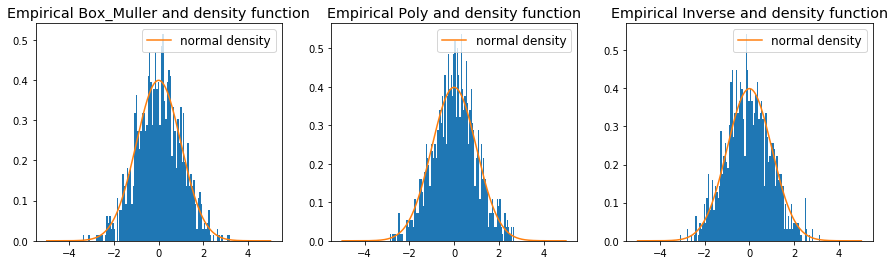

In [412]:
# 1.2 Compare empirical with density function
N = 1000
bm_x = box_muller(N)
poly_x = poly(N)
inverse_x = inverse(N)

nrbins = 100
xrange = np.linspace(-5, 5, N)
noraml_dx = np.exp(- xrange ** 2 /2 ) / (2 * math.pi) ** 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.hist(bm_x, bins=nrbins, density=1)
plt.plot(xrange, noraml_dx, label='normal density')
plt.legend(loc='best')
plt.title('Empirical Box_Muller and density function')


plt.subplot(1, 3, 2)
plt.hist(poly_x , bins=nrbins, density=1)
plt.plot(xrange, noraml_dx, label='normal density')
plt.legend(loc='best')
plt.title('Empirical Poly and density function')



plt.subplot(1, 3, 3)
plt.hist(inverse_x , bins=nrbins, density=1)
plt.plot(xrange, noraml_dx, label='normal density')
plt.legend(loc='best')
plt.title('Empirical Inverse and density function')
plt.show()



In [411]:
# 1.3 Compare the efficiency of the algorithms
import timeit
%timeit box_muller(N)
%timeit poly(N)
%timeit inverse(N)
%timeit np.random.randn(N)


648 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.04 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
874 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
366 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Comment: Efficiency
Obviously, the python libary is the fastest. box_muller the second and inverse method the third. 

Poly method should be ignored here as $2N$ samples actually have been draw to give enough $N$ result. Maybe some improvement could be made to Poly method 

##  Exercise 2: Brownian Motion

In [127]:
# 2.1
def genBMpath(T, n, plot=True): 

    step = T / n
    tg = np.arange(0, T + step, step) # time grird: tg[0] = 0,  tg[-1] = T, tg length: n + 1 (t0, t1, ..., tn)
    tid = np.arange(0,n + 1) 

    dW = 0 + step ** 0.5 * np.random.randn(n)  # dW: increments
    Wt0 = 0
    Ws = np.hstack((Wt0, np.cumsum(dW)))       # W: path of the Brownian motion
    dWs = np.hstack((Wt0, dW))

    if plot == True: 
        plt.plot(tg, Ws, label='Brownian motion path')
        plt.plot(tg, dWs, label='increment in each time step')
        plt.xlabel('time')
        plt.ylabel('value')
        plt.legend(loc='best')
        plt.title('Generated one Brownian motion path with n =' + str(n))
        
    return None    

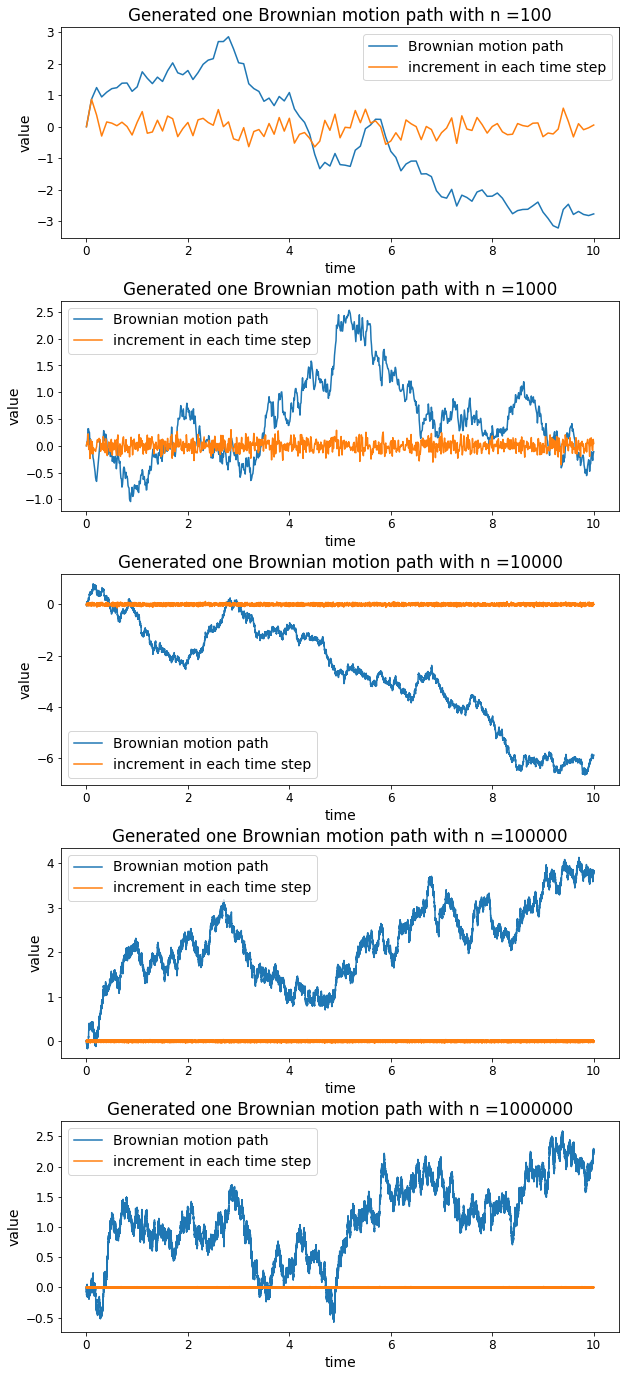

In [128]:
# 2.2 
T = 10
ns = 10 ** np.arange(2, 7)
Nr_plot = len(ns) 

plt.figure(figsize=(10, 24))
for i in np.arange(Nr_plot):
    n = ns[i]
    plt.subplot(Nr_plot,1,  i + 1) # subplot(nrows, ncols, index, **kwargs)
    genBMpath(T, n, plot=True)
    plt.subplots_adjust(wspace=0, hspace=0.3) 
plt.show()


#### Comment: 
As we can see, the increment $dW$ seems to be indeed independent of each other, and follows a normal distribution. When the time step increases, the variance of the increment $dW$ seems to be decreasing. That is true because the increment follows a  $\mathcal{N}(x; 0, \sqrt{\frac{1}{n}})$. The path of the Browian motion becomes smoother because of the reduced variance of the increment when $n$ increases.  



## Exercise 3: Black-Scholes Model

The dynamics of the price (simplified one-dimension) under the risk-neutral probability is as follows: 
$$dX_t = \gamma X_tdt + \sigma X_t d W_t$$

And, 


$$X_t = X_0 \exp((\gamma - \frac{\sigma^2}{2})t + \sigma W_t)$$
$$X_{t_{i+1}} = X_{t_i} \exp((\gamma - \frac{\sigma^2}{2})dt + \sigma dW_t)$$


In [353]:
# 3.1 and 3.3

def simXt(T,n, m=n, x0=1, gamma=0.5, sigma=1, plot=True): 
    
    stepn = T / n 
    tgn = np.arange(0, T + stepn, stepn) # time grird: tg[0] = 0,  tg[-1] = T, tg length: n + 1 (t0, t1, ..., tn)
    tid = np.arange(0, n + 1) 

    dWn = 0 + stepn ** 0.5 * np.random.randn(n)  # dW: increments, follow a normal distribution
    dtn = np.ones((n+1)) * stepn 
    dWns = np.hstack((Wt0, dWn))
    dWns_cumsum = np.hstack((0, np.cumsum(dWns)))
    
    exp_power_part = (gamma - sigma ** 2 / 2) * dtn + sigma * dWns 
    Xs = np.zeros((n+1))
    Xs[0] = x0
    
    for i in range(n): 
        Xs[i+1] = Xs[i] * np.exp(exp_power_part[i])    
 


    # 3.3 We simulate with Euler scheme
    # with the same underlying Brownian motion as the Formula schme
    stepm = T / m 
    Euler_Xs = np.zeros((m+1))
    if m <= n: 
        step_times = math.floor(stepm / stepn)
        m_in = np.arange(0,len(tgn), step=step_times)
        
        dWms_cumsum = dWns_cumsum[m_in]
        dWms = np.diff(dWms_cumsum)
        # dWms = dWns[m_in] / (step ** 0.5) *  stepm ** 0.5 
    else:     
        dWm =  0 + step ** 0.5 * np.random.randn(m)
        dWms = np.hstack((Wt0, dWm)) 
    
    Euler_Xs[0] = x0
    
    for i in range(m): 
        Euler_Xs[i+1] = Euler_Xs[i] + gamma * Euler_Xs[i] * step + sigma * Euler_Xs[i] * dWms[i]
         
    return Xs, Euler_Xs 


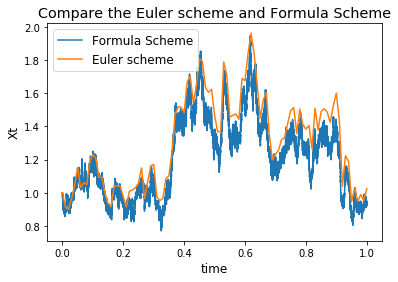

In [428]:
# 3.2 and 3.4  We plot the simulated path

T = 1 
n = 10 ** 5
m = 10 ** 2
Xs, Euler_Xs = simXt(T,n, m) 
    
    
tgn = np.arange(0, T +  T / n ,  T / n )
plt.plot(tgn,Xs, label='Formula Scheme')
tgm = np.arange(0, T + T / m, T / m )
plt.plot(tgm,Euler_Xs, label='Euler scheme')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('Xt')
plt.title('Compare the Euler scheme and Formula Scheme')
plt.show()

### Comment:
When the underlying Brownian motion of the two scheme are the same, they follow the path very close to each other. However, the Euler scheme is much smoother. 

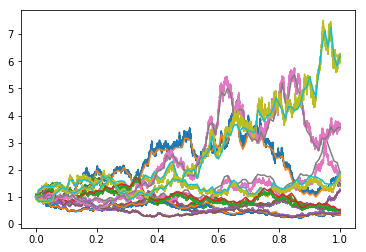

In [421]:
T = 1 
n = 10 ** 5
m = 10 ** 2

num_paths = 10
Xps = np.zeros((num_paths, n+1))
Eps = np.zeros((num_paths, m+1))
for i in range(num_paths):
    Xs, Euler_Xs = simXt(T,n, m) 
    Xps[i,:] = Xs
    plt.plot(tgn,Xs)
    plt.plot(tgm,Euler_Xs)

  
    